# Assignment 08

**Due:** 2020-05-04 (Mon), 11:59 PM, as a Jupyter notebook (with related files) submitted via your repo in the course GitHub organization.  Use the solutions template notebook, and **be sure not to modify the subproblem cells** in your solution file.  This assignment is **mandatory**.

**NOTE:** Doing all of the calculations for these problems entirely in your Solutions Jupyter notebook may make the notebook unwieldy (both to work on, and to grade).  In addition, you will probably find it easier to debug parts of your work in a script rather than in a notebook.

Accordingly, aim to execute *just a single fit in your solution notebook* for this assignment.  Other work can be done in a script, with figures saved as PNG files via matplotlib's `savefig` command, and placed in the notebook in a Markdown cell. You can use standard Markdown markup for inserting images, e.g., `![Description](imag-file-name.png)`. Alternatively, you can use an HTML tag, which lets you control the image size in the notebook (see Markdown cells below for examples).

If you prefer debugging in a Jupyter notebook, note that you can convert a notebook to a script (but not the other way around) by using Jupyter's `nbconvert` command in the terminal.  For example,

    jupyter nbconvert --to script Solutions08.ipynb

will convert the solutions template notebook into a Python script named "Solutions08.py".  You may rename that, but indicate the name (or names) of the scripts you used for results placed in the notebook in the next Markdown cell.

**Make sure you commit, not just your notebook, but also all of the Python modules, scripts, and images needed to run the notebook and to produce the content included in it.**

**Do not commit your cached Stan model files.** Those are platform-dependent.

## Use our .gitignore file

In the LabResources repo, at the top level, you'll find a file named `bda20.gitignore`.
* Copy it to the top level of your assignments repo (the same folder holding the hidden `.git` folder).
* Rename it to `.gitignore` (note the leading `.`). This will probably result in the file becoming hidden (like the `.git` folder). That's fine.
* `git` or your Git GUI may prompt you to track the `.gitignore` file. You may do so, but it's not strictly necessary.

This file tells `git` what types of files **not** to track. In particular, it will prevent `git` from suggesting that you track cached Stan model files, or cached compiled Python code.

## Accompanying scripts:

myscript.py **<-- EDIT identifying accompanying scripts**

In [1]:
# The usual imports:
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from numpy import *
from scipy import stats

In [2]:
ion()

## Linear regression and global warming

**Note:  This exercise does not comprise a serious analysis of global warming data!**  This exercise is meant to give you some experience with both linear regression and Stan, and to help you gain some insight into issues, both subtle and not-so-subtle, that arise in trying to predict the behavior of a complex system using *phenomenological models* (i.e., not physical or first-principles models; see [Phenomenological model - Wikipedia](https://en.wikipedia.org/wiki/Phenomenological_model)).

A Python module, implemented in `climate_helpers.py`, accompanies this assignment; it includes both code and data you'll use for your solutions.  Also, the StanFitter module, `stanfitter.py`, which you used earlier, accompanies this assignment.

In [3]:
from climate_helpers import giss_temp_data, years, dTs, MonomialBasis, ChebyshevBasis
from stanfitter import StanFitter

The `climate_helpers` module provides time series data from NASA's Goddard Institute for Space Science (GISS). GISS scientists carefully compute the *Global Annual Mean Surface Air Temperature Change* (reported as a *temperature anomaly*, i.e., a temperature change from a fiducial period, in degrees C) based on a wide array of input data, available back to 1880.  The data are hosted [at GISS](https://data.giss.nasa.gov/gistemp/); NASA hosts several web sites discussing this and other data pertinent to climate change, including [sites directed to a nontechnical audience](http://climate.nasa.gov/vital-signs/global-temperature/).

Computing global temperatures and temperature changes is a tricky business.  If you'd like to learn more about it, check out these resources:
* [Pubs.GISS: Hansen et al. 2010: Global surface temperature change](https://pubs.giss.nasa.gov/abs/ha00510u.html) — This describes the methodology used to produce the GISS data.
* [Climate Resource Center - Earth's temperature record](https://climate.nasa.gov/climate_resources/9/graphic-earths-temperature-record/)
* [Why so many global temperature records?](https://climate.nasa.gov/news/2241/why-so-many-global-temperature-records/)
* ["Berkeley Earth: raw versus adjusted temperature data " (Climate Etc. blog)](http://judithcurry.com/2015/02/09/berkeley-earth-raw-versus-adjusted-temperature-data/)

Here's what the GISS time series looks like:

Text(0, 0.5, '$\\Delta T$ (C)')

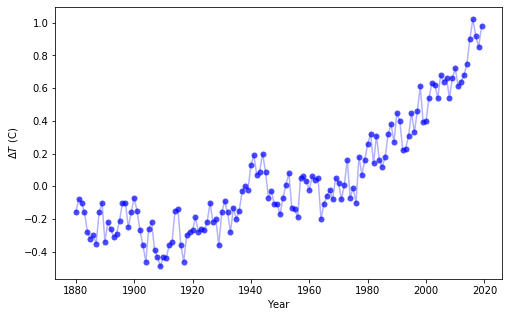

In [4]:
temp_fig = figure(figsize=(8,5))
temp_ax = axes()
plot(years, dTs, 'b-', alpha=.3)
# plot(years, dTs, ls='None', marker='o', ms=8, mfc='b', mew=0, alpha=.7)
plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
xlabel('Year')
ylabel(r'$\Delta T$ (C)')

In this exercise, we'll explore fitting the data, and predicting the future temperature anomaly to 2050, based on linear regression in a polynomial basis, with a normal conditional distribution for the temperature anomaly at a given time (reflecting a combination of natural variation and measurement error; we'll determine the width of the conditional distribution from the data).

We'll consider _**two different polynomial bases**_, covering times out to 2050:

In [5]:
# Extended array of years, including prediction interval:
xyears = arange(years[0], 2051.)

The module provides two classes for building polynomials and evaluating them on an array of times to build the set of basis functions for regression (aka, the design matrix).  One uses the familiar **monomials** (1, $x$, $x^2$, $x^3$, $\ldots$).  The other uses **Chebyshev polynomials**, an *orthogonal basis* (see [Chebyshev Polynomial of the First Kind at MathWorld](https://mathworld.wolfram.com/ChebyshevPolynomialoftheFirstKind.html) and [Chebyshev polynomials at Wikipedia](http://en.wikipedia.org/wiki/Chebyshev_polynomials); the first few basis functions are 1, $x$, $2x^2-1$, $4x^3 - 3x$).  The classes that define them for you also let you define **independent normal priors over the polynomial coefficients**, so we can study how the choice of basis and priors may potentially influence inferences.

Take a look at the code so you have a basic grasp of how the bases are computed (you won't be modifying the code, so you needn't understand it in detail).  Note that, internally, the classes map the years to a variable $x \in [-1,1]$, to help make the basis functions numerically well-behaved and of similar scale to each other.

In [6]:
# 5th-degree bases with zero-mean priors, sig=2:
deg = 5  # number of terms = deg + 1
mono = MonomialBasis(deg, xyears, sigma=2.)
cheb = ChebyshevBasis(deg, xyears, sigma=2.)

After creating a basis instance, the **`basis`** attribute (e.g., `mono.basis`) is a 2-D array `basis[i,j]` that gives the value of basis function `j` at time `i`; this is the transpose of the $g_{\alpha i}$ matrix from the lectures on regression, i.e., it is the design matrix.

There are two methods that you'll use.  For a 1-D array of coefficients, `beta`, the method call **`func(beta)`** evaluates the polynomial defined by `beta` over all the times (years), returning a 1-D array of values $f_i$, with
$$
f_i = \sum_j \beta_j g_j(t_i),
$$
where $g_j(t)$ is basis function $j$.

The method call **`sample()`** returns a polynomial sampled from the prior, as a 1-D array of values at all the times.  That is, it samples $\beta_j$ values from the priors, and then evaluates the polynomial with those coefficients.  As a (deliberately vague!) example, one choice of basis and degree produces this set of 50 prior samples:

<img width=650 src="climate-PolyPriorSamplesEx.png">

### Problem 1 (1 point):

> * Make a 2-panel plot (use `figure(figsize=(...))` and `subplot(...)` with appropriate arguments), showing 50 samples from each of the two degree 5 bases just defined.  Be sure to title the subplots, identifying the cases.  If done correctly, the two plots should look quite different.
> * From the perspective of an investigator wanting to be noncommital about global temperature trends a priori, which basis/prior combination appears to be the better one to you?  Briefly explain why.

For a problem where there aren't clear principles defining a unique prior, a good Bayesian analysis will be concerned with *robustness of conclusions with respect to priors*.  The investigator should examine how much the findings are affected by reasonable changes in priors.

Here, one way you'll get a handle on robustness to priors is to try fits with **both** bases.  Even if you use priors of the same form for the coefficients in both bases, these priors express quite different prior distributions over the space of polynomials. (That is, even though we are using the name `beta` or the symbols $\beta_\alpha$ for the coefficients in each basis, the coefficients mean something different for each basis, so assigning the *same* prior PDFs over them corresponds to *different* priors over the space of polynomials. We could make this extra clear by giving different names to the coefficients in each case, but that would make the code unwieldy.)

Importantly, you will also explore robustness of inferences with respect to the **degree** of the basis.  The degree is essentially a discrete parameter.  A more complete analysis than you'll pursue here would try to quantify uncertainty in the polynomial degree (e.g., via Bayes factors or out-of-sample predictive criteria).  You'll explore that degree of freedom in this problem only qualitatively here.

You now have data and basis functions for linear models; next do some fits.

### Problem 2 (1 point):

> * Below you'll find incomplete Stan code for a linear regression model for the global warming data.  The `model` section is empty.  Complete it, consulting the [Stan Modeling Language User's Guide](http://mc-stan.org/users/documentation/index.html) for how to build regression models in Stan (see Section 1.1, on linear regression; note that the basis functions include the "intercept" term discussed at the end of that section).  The model code should have three main ingredients:
    * Priors for the coefficients (set in a loop over the coefficients in the `beta` vector); use zero-mean normal priors with $\sigma = 2$, as used for your prior sample plots.
    * A prior for $\sigma$, the conditional standard deviation for the temperature measurements.  Adopt an exponential prior with a mean of 2., a broad prior compared to the visual scale of the temperature fluctuations over short time spans.
    * A sampling distribution (defining the likelihood function) for the temperature change data vector.  Do this using Stan's implicit looping capability (i.e., write it without using a `for` loop; this is discussed in that same section).
> * Compile the model with StanFitter.

Note that since the basis gets passed in as "data" (including the number of coefficients) *you only need a single fitter instance* to fit multiple models with different bases and degrees.  You'll only have to alter the code and recompile it if you change the priors (other than changing the bases).

In [7]:
# Stan code for linear regression:
lin_regn_code = """
data {
    int<lower=0> n; // number of times sampled
    int<lower=0> m; // number of coeff = deg + 1
    matrix[n,m] basis; // basis funcs, aka design matrix
    vector[n] dT; // temp change
}

parameters {
    vector[m] beta;  // coeficients
    real<lower=0> sigma;  // noise scale
}

model {
    // FILL IN HERE; SEE STAN MANUAL
}
"""

# Uncomment to compile finished code:
# fitter = StanFitter(lin_regn_code, name='lin_regn')

You'll use the `fitter` instance as we did in previous exercises, but you'll use some new capabilities.

`fitter.mode()`

runs Stan's default optimizer, returning the posterior mode as an object with both a dict and an attribute interface to the parameter values and the log density.  That is, if you write

    mode = fitter.mode()

then `mode.sigma` and `mode['sigma']` are both ways to access the value of $\sigma$ at the mode, and `mode.beta` and `mode['beta']` are *arrays* with the values of the coefficients at the mode. Likewise, `mode.log_p` and `mode['log_p']` give the log of the posterior density at the mode.

_**IMPORTANT NOTE:**_ `Stan` treats arrays as 1-based (the first element of `beta` is accessed using `beta[1]`), while Python treats arrays as 0-based (the first element is accessed using `beta[0]`).

The `StanFitResults` instance returned by

    fit = fitter.sample(...)

has useful attributes you may not have explored yet.  After sampling, the fitter finds the smallest ESS among the parameter Markov chains, and uses it to provide an array of samples for each parameter constructed by thinning the chains and concatenating them, for each parameter. You may find the following attributes and methods useful for working with the thinned chains.
* `fit.min_ess` tells you the smallest ESS among the parameter Markov chains.
* `fit.thinned_by` tells you by how much each chain was thinned.
* `fit.sigma.thinned`, `fit.beta[0].thinned`, etc., give you access to the thinned, merged chain for each parameter (including `log_p`).
* `fit.subsample_indices(n)` returns a list of `n` randomly chosen indices into the thinned, merged chains, which you can use to pull out a subset of posterior samples chosen fairly across the merged chains.
* `fit.point(t)` returns all of the parameter values at time `t` in the set of thinned chains.  It's the same kind of object as is returned by `fitter.mode()`.

You'll use these capabilities to produce plots resembling this one:

<img width=650 src="climate-PolyFitEx.png">

### Problem 3 (2 points):

> * Write a function, `fit_model`, building on the stub provided below, that does the following, producing a single plot:
  * Build a basis of specified type and degree.
  * Fit the data, obtaining the posterior mode and posterior samples.
  * Plot the data.
  * Plot 40 polynomials sampled from the posterior, as thin curves with colors automatically chose by matplotlib.  Use a small `alpha` opacity (say, .2), so curves remain visible despite overlap.
  * Plot a thick dashed curve showing the polynomial corresponding to the mode.
  * Plot a single error bar somewhere along the curve displaying the value of $\sigma$ at the mode.
  * Return the (MCMC) fit results and mode.
> Your work for this subproblem should all be in the next single cell; you'll *use* the function below.

In [8]:
def fit_model(fitter, Poly, deg, csig, n_iter=1000, n_chains=4,
              years=years, dTs=dTs, xyears=xyears):
    """
    Fit the data and summarize results.

    Parameters
    ----------
    
    fitter : StanFitter instance
    
    Poly : Polynomial basis class
    
    deg : int
        Degree of polynomial to fit

    csig : float
        Coeffient prior standard deviation

    n_iter, n_chains : int
        The number of iterations per chain, and number of chains, for Stan fits

    years, dTs, xyears : float arrays
        Data (years, dTs) and extended years covering data and prediction
        interval (xyears)
    """
    nbeta = deg + 1  # number of coefs
    # Build a basis over the fit+prediction interval.
    poly = Poly(deg, xyears, sigma=csig)
    # For fitting the data, pull out the part spanning years.
    data_basis = poly.basis[:len(years),:]
    # Data dict for Stan:
    data = dict(n=len(years), m=nbeta, basis=data_basis, dT=dTs)

    # Do the fit, MCMC and optimization:
    fitter.set_data(data)
    fit = fitter.sample(n_iter, n_chains)
    mode = fitter.mode()

    # Plot dTs:
    temp_fig = figure()
    temp_ax = axes()
    plot(years, dTs, 'b-', alpha=.3)
    plot(years, dTs, ls='None', marker='o', ms=6, mfc='b', mew=0, alpha=.7)
    xlabel('Year')
    ylabel(r'$\Delta T$ (C)')
    xlim(xyears[0], xyears[-1])
    ylim(-1.5, 1.5)

    # MUCH MORE HERE
    
    return fit, mode
    

### Problem 4 (2 points):

> * Use `fit_model` to use both the monomial and Cheybshev bases to fit **4th degree** polynomials to the data, with the coefficient priors having standard deviation `csig=2.0`.  The notebook should execute one of the `fit_model` calls, but you should execute the other in a script, just including the plot in the notebook.  Use the returned `fit` objects to assure yourself of convergence and good mixing.  You need not provide plots and printouts in the notebook for this, but you should have a Markdown cell *briefly* describing what you did regarding output diagnostics.
> * Briefly comment on what the two fits tell you about sensitivity of the results to the prior over polynomials.

### Problem 5 (2 points):

> * Use `fit_model` to use both monomial and Cheybshev bases to fit **5th degree** polynomials to the data, with a prior standard deviation `csig=2.`.  Show the plots you produce in the notebook, clearly identified (the code should be in a separate script).
> * In words, compare the 4th degree and 5th degree results, and briefly comment on the implications of the difference for using phenomenological vs. physical models to make predictions from climate data.